# **Predict Future Sales**
> Original code : [Extensive EDA + Feature engineering + Xgboost by ARUNMOHAN_003](https://www.kaggle.com/code/arunmohan003/extensive-eda-feature-engineering-xgboost)

## Data field

#### **Target) item_cnt_day** : number of products sold.
**ID** : an Id that represents a (Shop, Item) tuple within the test set | **shop_id** : unique identifier of a shop  
**item_id** : unique identifier of a product | **item_category_id** : unique identifier of item category  
**item_price** : current price of an item | **date** : date in format dd/mm/yyyy  
**date_block_num** : a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33  
**item_name** : name of item | **shop_name** : name of shop | **item_category_name** : name of item category  

  
- `train.csv` : showing item price and number of items sold on each date. 
- `shop.csv` : Details of shops corresponding to shop id in `train.csv`.
- `item.csv` : Details of items corresponding to item id in `train.csv`
- `item_categories.csv` : Details of item category corresponding to category id in `item.csv`
- `test.csv` : test data for prediction

- time-series dataset(sales for 34 months from 2013 Jan to 2015 October) consisting of daily sales data, provided by one of the largest Russian software firms - 1C Company

## **0. Import Packages**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import stats
from termcolor import colored
import gc,time,os


plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

## **1. Load and make dataset**

In [2]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00


In [3]:
df_shop = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [4]:
df_item = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
df_itemcat = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
df_itemcat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


- As discussed earlier for test data we just have shop id and item id. Train data is spread over 4 files.
- From above samples we know that there are common ids on multiple files.It will be great to move forward once we merge those train files based on common id.


In [7]:
# Merging all dataframes together
dff = df_train.merge(df_item, on="item_id")
dff = dff.merge(df_itemcat, on="item_category_id")
dff = dff.merge(df_shop, on="shop_id")
dff = dff.drop(columns=["item_name"])

# masking a copy
df = dff.copy()
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.00,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.00,1.00,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.50,1.00,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.50,1.00,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.00,2.00,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [8]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


## **2. EDA**

### 2-(1). `Date`

In [9]:
df["date"] = pd.to_datetime(df["date"], format='%d.%m.%Y')
df.sort_values(by="date", ascending=True, inplace=True)

print(f'Minimum data present: {df["date"].min()}')
print(f'Maximum date present: {df["date"].max()}')

Minimum data present: 2013-01-01 00:00:00
Maximum date present: 2015-10-31 00:00:00


In [10]:
# sorting dataframe based on date
df = df.sort_values(by='date').reset_index(drop=True)
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
0,2013-01-01,0,18,2589,279.00,1.00,55,Музыка - CD локального производства,"Красноярск ТЦ ""Июнь"""
1,2013-01-01,0,42,13511,1589.00,1.00,19,Игры - PS3,"СПб ТК ""Невский Центр"""
2,2013-01-01,0,28,4481,1698.70,1.00,22,Игры - PSVita,"Москва ТЦ ""МЕГА Теплый Стан"" II"
3,2013-01-01,0,42,17696,1997.51,1.00,19,Игры - PS3,"СПб ТК ""Невский Центр"""
4,2013-01-01,0,28,2304,1999.00,2.00,22,Игры - PSVita,"Москва ТЦ ""МЕГА Теплый Стан"" II"


- Our `date` was not in date time format. We have converted it to datetime and sorted our dataframe based on that.

### 2-(2). `item_cnt_day`
- number of units of that item sold in that shop on a particular day.

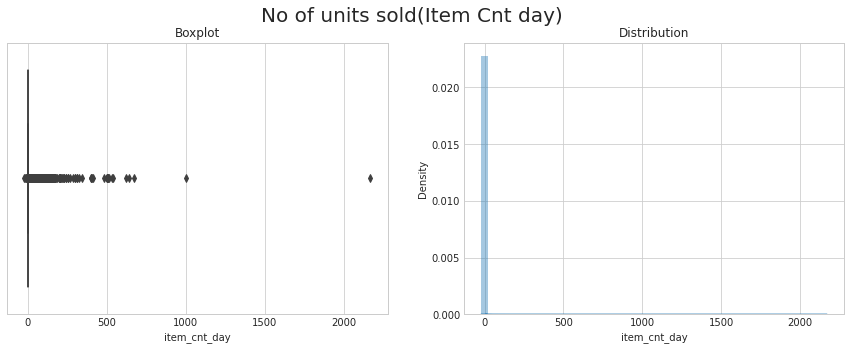

In [11]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(df['item_cnt_day'],ax=axes[0])
axes[0].set_title('Boxplot')

sns.distplot(df['item_cnt_day'],ax=axes[1])
axes[1].set_title('Distribution')

plt.suptitle('No of units sold(Item Cnt day)',fontsize= 20)
plt.show()

In [12]:
df['item_cnt_day'].describe()

count   2935849.00
mean          1.24
std           2.62
min         -22.00
25%           1.00
50%           1.00
75%           1.00
max        2169.00
Name: item_cnt_day, dtype: float64

In [13]:
print(f'Minimum value {df["item_cnt_day"].min()}')
print(f'Maximum value {df["item_cnt_day"].max()}')

Minimum value -22.0
Maximum value 2169.0


- -22 does not make sense. We will remove those values under 0

In [14]:
# Let us print percentile values
for i in range(0,101,10):
    print(f'{i}th percentile value for item_cnt_day is {np.percentile(df["item_cnt_day"],i)}')
    
print('--'*50)

for i in range(90,100):
    print(f'{i}th percentile value for item_cnt_day is {np.percentile(df["item_cnt_day"],i)}')
    
print('--'*50)

for i in range(1,10):
    k = 99 + i/10 
    print(f'{k}th percentile value for item_cnt_day is {np.percentile(df["item_cnt_day"],k)}')

0th percentile value for item_cnt_day is -22.0
10th percentile value for item_cnt_day is 1.0
20th percentile value for item_cnt_day is 1.0
30th percentile value for item_cnt_day is 1.0
40th percentile value for item_cnt_day is 1.0
50th percentile value for item_cnt_day is 1.0
60th percentile value for item_cnt_day is 1.0
70th percentile value for item_cnt_day is 1.0
80th percentile value for item_cnt_day is 1.0
90th percentile value for item_cnt_day is 2.0
100th percentile value for item_cnt_day is 2169.0
----------------------------------------------------------------------------------------------------
90th percentile value for item_cnt_day is 2.0
91th percentile value for item_cnt_day is 2.0
92th percentile value for item_cnt_day is 2.0
93th percentile value for item_cnt_day is 2.0
94th percentile value for item_cnt_day is 2.0
95th percentile value for item_cnt_day is 2.0
96th percentile value for item_cnt_day is 2.0
97th percentile value for item_cnt_day is 3.0
98th percentile valu

In [15]:
# we will remove some extreme out layers
df[df['item_cnt_day'] > df['item_cnt_day'].quantile(0.95)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
8,2013-01-01,0,54,22092,109.00,5.00,83,Элементы питания,"Химки ТЦ ""Мега"""
69,2013-01-01,0,46,1830,599.00,3.00,30,Игры PC - Стандартные издания,"Сергиев Посад ТЦ ""7Я"""
98,2013-01-01,0,54,13351,70.00,4.00,82,Чистые носители (штучные),"Химки ТЦ ""Мега"""
238,2013-01-01,0,54,19899,149.00,3.00,40,Кино - DVD,"Химки ТЦ ""Мега"""
300,2013-01-01,0,54,3870,598.83,3.00,30,Игры PC - Стандартные издания,"Химки ТЦ ""Мега"""
...,...,...,...,...,...,...,...,...,...
2935729,2015-10-31,33,50,17717,1124.75,4.00,79,Служебные,"Тюмень ТЦ ""Гудвин"""
2935733,2015-10-31,33,48,20949,5.00,4.00,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Томск ТРЦ ""Изумрудный Город"""
2935758,2015-10-31,33,59,19655,299.00,3.00,40,Кино - DVD,"Ярославль ТЦ ""Альтаир"""
2935806,2015-10-31,33,7,9355,349.00,3.00,70,Подарки - Сувениры (в навеску),"Воронеж ТРЦ ""Максимир"""


In [16]:
df[df['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
146,2013-01-01,0,27,12269,1499.00,-1.00,62,"Подарки - Гаджеты, роботы, спорт","Москва ТЦ ""МЕГА Белая Дача II"""
694,2013-01-01,0,18,6724,299.50,-1.00,21,Игры - PSP,"Красноярск ТЦ ""Июнь"""
708,2013-01-01,0,19,20383,1229.00,-1.00,72,Подарки - Фигурки,"Курск ТЦ ""Пушкинский"""
828,2013-01-01,0,19,13086,1499.00,-1.00,62,"Подарки - Гаджеты, роботы, спорт","Курск ТЦ ""Пушкинский"""
959,2013-01-01,0,54,3429,2799.00,-1.00,23,Игры - XBOX 360,"Химки ТЦ ""Мега"""
...,...,...,...,...,...,...,...,...,...
2933097,2015-10-30,33,22,8546,1299.00,-1.00,42,"Книги - Артбуки, энциклопедии",Москва Магазин С21
2933118,2015-10-30,33,36,10207,1199.00,-1.00,30,Игры PC - Стандартные издания,"Новосибирск ТРЦ ""Галерея Новосибирск"""
2934259,2015-10-31,33,42,16790,2464.00,-1.00,20,Игры - PS4,"СПб ТК ""Невский Центр"""
2934429,2015-10-31,33,38,1846,1199.00,-1.00,23,Игры - XBOX 360,"Омск ТЦ ""Мега"""


In [17]:
print(f'shape of data after before outliers: {df.shape}')

df = df[df['item_cnt_day'] >= 0]
upper_quantile = df['item_cnt_day'].quantile(0.95)

print(f'Removing values greater that upper_quantile {upper_quantile} and less than 0')
df['item_cnt_day'] = np.where(df['item_cnt_day'] > upper_quantile, upper_quantile, df['item_cnt_day'])

print(f'shape of data after removing outliers: {df.shape}')
print(f'Minimum units of product sold a time {df["item_cnt_day"].min()}')
print(f'Maximum units of product sold a time {df["item_cnt_day"].max()}')

shape of data after before outliers: (2935849, 9)
Removing values greater that upper_quantile 2.0 and less than 0
shape of data after removing outliers: (2928493, 9)
Minimum units of product sold a time 1.0
Maximum units of product sold a time 2.0


- Most of the items are only sold 1 in quantity. Even 75th percentile value is 1.
- We have some values less that zeros which ideally should not present. i.e., the number of units sold cannot be less than or equal to zero.
- Also we have some extreme outliers. After some analysis, we decide to remove all those values > 0.95 percentile.

### 2-(3). `item price`

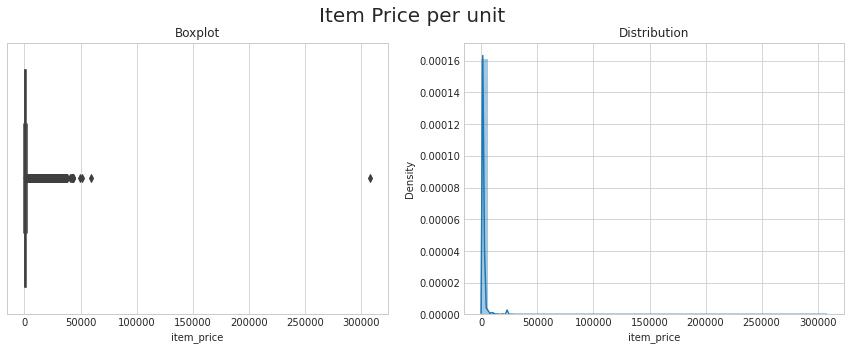

In [18]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(df['item_price'],ax=axes[0])
axes[0].set_title('Boxplot')

sns.distplot(df['item_price'],ax=axes[1])
axes[1].set_title('Distribution')

plt.suptitle('Item Price per unit', fontsize = 20)
plt.show()

In [19]:
df['item_price'].describe()

count   2928493.00
mean        889.47
std        1727.50
min          -1.00
25%         249.00
50%         399.00
75%         999.00
max      307980.00
Name: item_price, dtype: float64

- Item price < 0 is not acceptable.

In [20]:
# Let us print percentile values
for i in range(0,101,10):
    print(f'{i}th percentile value for item_price is {np.percentile(df["item_price"],i)}')
    
print('--'*50)

for i in range(90,100):
    print(f'{i}th percentile value for item_price is {np.percentile(df["item_price"],i)}')
    
print('--'*50)

for i in range(1,10):
    k = 99 + i/10 
    print(f'{k}th percentile value for item_price is {np.percentile(df["item_price"],k)}')

0th percentile value for item_price is -1.0
10th percentile value for item_price is 149.0
20th percentile value for item_price is 199.0
30th percentile value for item_price is 299.0
40th percentile value for item_price is 349.0
50th percentile value for item_price is 399.0
60th percentile value for item_price is 599.0
70th percentile value for item_price is 799.0
80th percentile value for item_price is 1199.0
90th percentile value for item_price is 1999.0
100th percentile value for item_price is 307980.0
----------------------------------------------------------------------------------------------------
90th percentile value for item_price is 1999.0
91th percentile value for item_price is 2072.0
92th percentile value for item_price is 2299.0
93th percentile value for item_price is 2499.0
94th percentile value for item_price is 2599.0
95th percentile value for item_price is 2683.561999999853
96th percentile value for item_price is 2999.0
97th percentile value for item_price is 3190.0
98

In [21]:
# we have an extreme outlier value in item price. Let us remove it

print(f'shape of data before removing outliers: {df.shape}')
df = df[df['item_price'] >= 0]
upper_quantile = df['item_price'].quantile(0.95)
df['item_price'] = np.where(df['item_price'] > upper_quantile, upper_quantile, df['item_price'])
print(f'shape of data after removing outliers: {df.shape}')

print(f'Minimum price of a single item {df["item_price"].min()}')
print(f'Maximum price ofa single item {df["item_price"].max()}')

shape of data before removing outliers: (2928493, 9)
shape of data after removing outliers: (2928492, 9)
Minimum price of a single item 0.07
Maximum price ofa single item 2683.6409999995585


- We have some item price less that zeros which ideally should not present.
- Also we have some extreme outliers. After some analysis, we decide to remove all those values > 0.95 percentile similar to `item_cnt_day`.
- After removing outliers, We have some products with price low as 0.07 (Might be some chocolate). Also we have some item which costs about 2683 (Might be a chair)

- There might be price change for the same item in different shops. So let us consider price development of sample of items in the same shop.

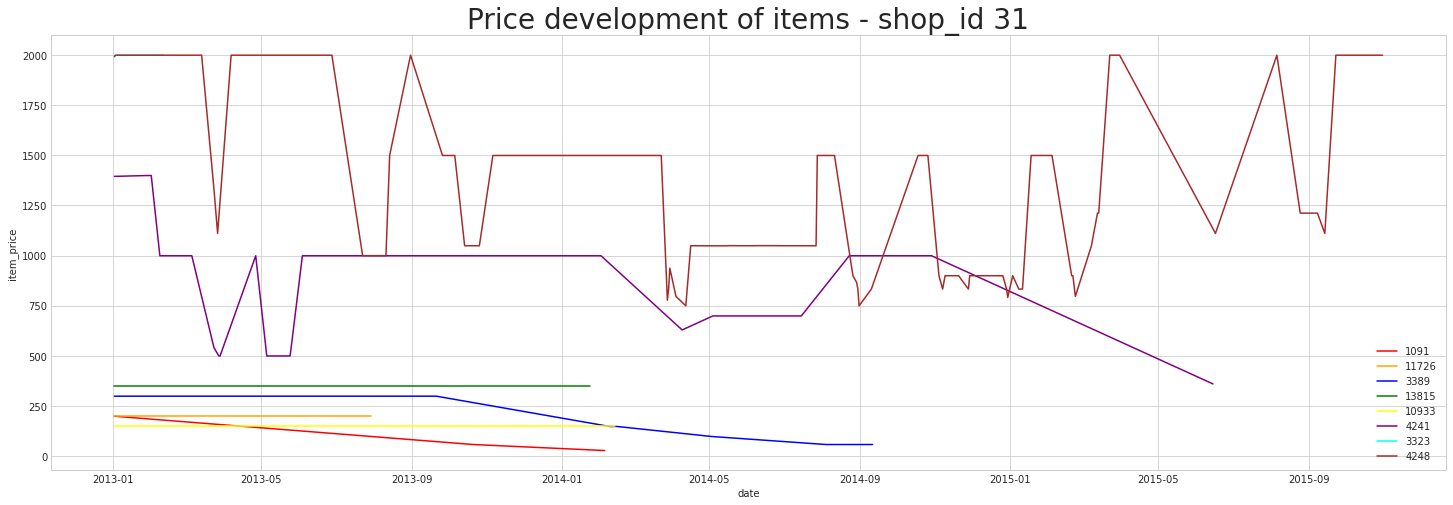

In [22]:
df_tmp = df[df['shop_id'] == 31][['date','item_id','item_price']].reset_index(drop=True)
items = df_tmp['item_id'].unique()[0:8]

fig,axes = plt.subplots(1,1,figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i,item in enumerate(items):
    dprice = df_tmp[df_tmp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'],y=dprice['item_price'],ax=axes,color=colors[i],label=item)
    
axes.set_title('Price development of items - shop_id 31',fontsize="28")
axes.legend()
plt.show()

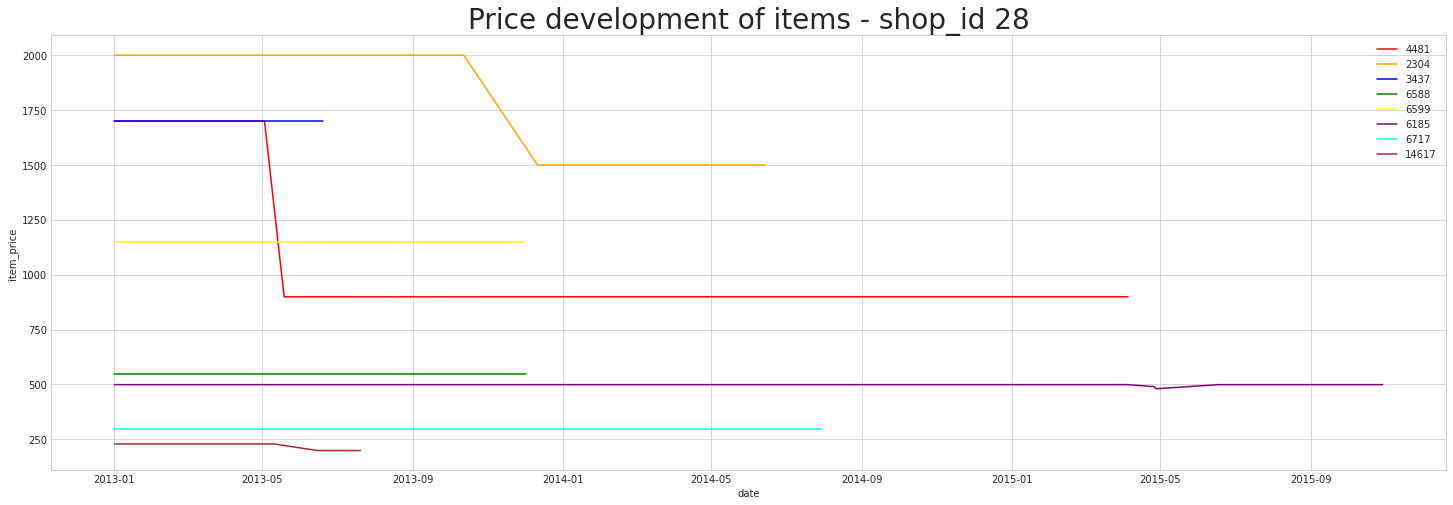

In [23]:
df_tmp = df[df['shop_id'] == 28][['date','item_id','item_price']].reset_index(drop=True)
items = df_tmp['item_id'].unique()[0:8]

fig,axes = plt.subplots(1,1,figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i,item in enumerate(items):
    dprice = df_tmp[df_tmp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'],y=dprice['item_price'],ax=axes,color=colors[i],label=item)
    
axes.set_title('Price development of items - shop_id 28',fontsize="28")
axes.legend()
plt.show()

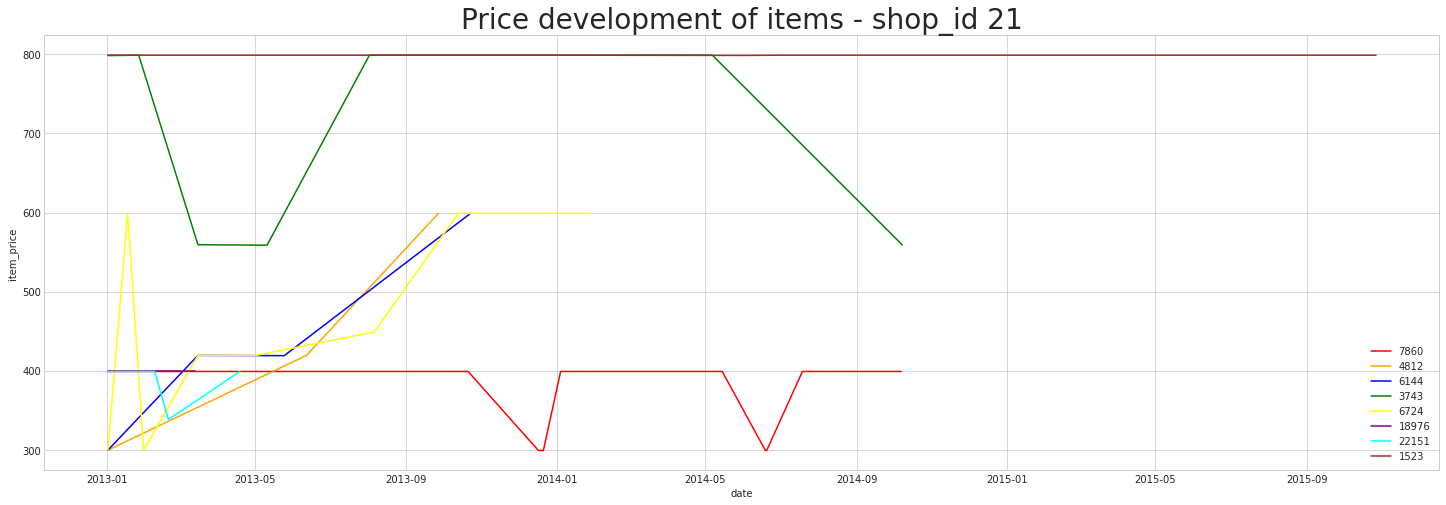

In [24]:
df_tmp = df[df['shop_id'] == 21][['date','item_id','item_price']].reset_index(drop=True)
items = df_tmp['item_id'].unique()[0:8]

fig,axes = plt.subplots(1,1,figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i,item in enumerate(items):
    dprice = df_tmp[df_tmp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'],y=dprice['item_price'],ax=axes,color=colors[i],label=item)
    
axes.set_title('Price development of items - shop_id 21',fontsize="28")
axes.legend()
plt.show()

- We can see that price of the same item is not same over the time (for some items).
- Some items are also **not** selling on shops after some time.
- It increases and decreases over time.
- During feature engineering it may be useful, if we can flag some items whose price remain constant over time.
- Here we can see that item price is **dependent on time**.

- How sales distribution looks for a single day. Before that let us create a **new feature** which is the turn over for an item.
- We can consider it as total sales for an item from a particular shop on a particular day.

In [25]:
# creating a new feature
df['Sales_per_item'] = df['item_cnt_day'] * df['item_price']

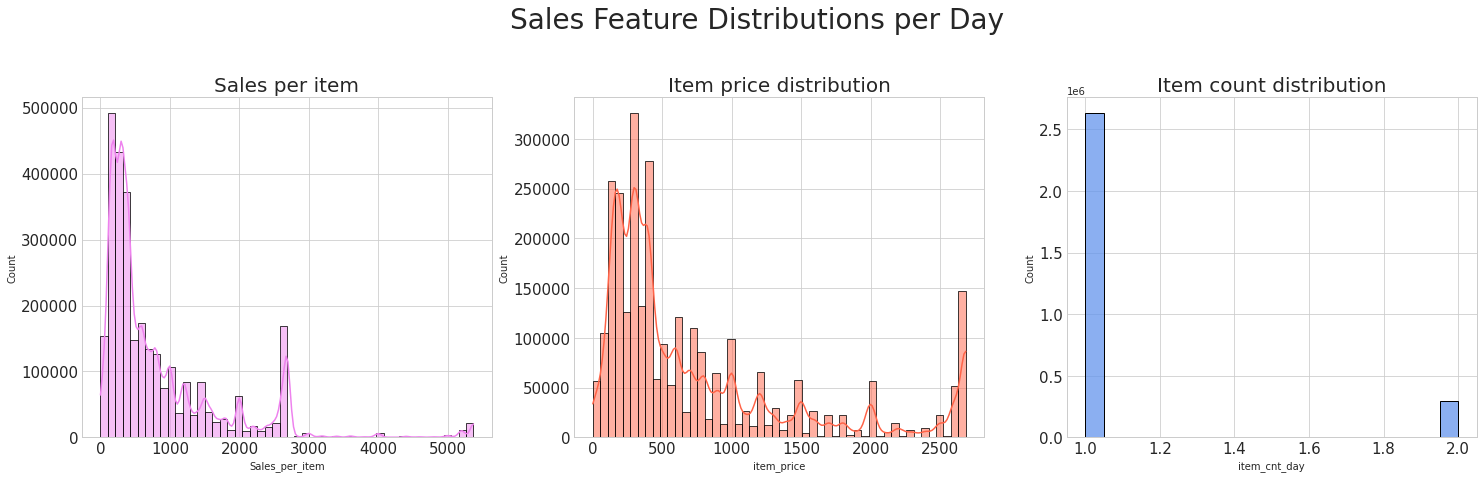

In [26]:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])

# setting size of xlabel and ylabel
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax02.tick_params(axis='both', labelsize=15)
ax00.set_title('Sales per item', fontsize=20)
ax01.set_title('Item price distribution', fontsize=20)
ax02.set_title('Item count distribution', fontsize=20)

sns.histplot(data = df ,x="Sales_per_item", kde=True, bins=50,ax=ax00, color="violet")
sns.histplot(data = df ,x="item_price", kde=True, ax=ax01, bins=50, color="tomato")
sns.histplot(data = df ,x="item_cnt_day", kde=False, ax=ax02, bins=20, color="cornflowerblue")

fig.subplots_adjust(top=0.8)
fig.suptitle('Sales Feature Distributions per Day', fontsize="28");

- We are looking at sales figure on daily basis. It is **different from our target** distribution
- In **most of the days only 1 item is sold**.
- We are also getting a clear idea on price range (after removing top 5% items.)

### 2-(4). `Shop_id`, `item_id` and `item_category_id`

- Do all `shop id`,`item id` and their pair present in test data present in train data and viceversa?

In [27]:
train_shop_ids = set(df['shop_id'].unique())
test_shop_ids = set(df_test['shop_id'].unique())

train_item_ids = set(df['item_id'].unique())
test_item_ids = set(df_test['item_id'].unique())

print(f'There are about {len(train_shop_ids)} unique shop ids in train data and {len(test_shop_ids)} shop ids in test data')
print(f'There are about {len(train_item_ids)} unique item ids in train data and {len(test_item_ids)} item ids in test data')

There are about 60 unique shop ids in train data and 42 shop ids in test data
There are about 21804 unique item ids in train data and 5100 item ids in test data


In [28]:
df['pair'] = df[['shop_id','item_id']].apply(lambda x: str(x['shop_id'])+'_'+str(x['item_id']),axis=1)
df_test['pair'] = df_test[['shop_id','item_id']].apply(lambda x: str(x['shop_id'])+'_'+str(x['item_id']),axis=1)
train_pair_ids = set(df['pair'].unique())
test_pair_ids = set(df_test['pair'].unique())

print(f'There are {len(train_shop_ids - test_shop_ids)} shop ids present in train data which are not in test data')
print(f'There are {len(train_item_ids - test_item_ids)} item ids present in train data which are not in test data')
print(f'There are {len(train_pair_ids - test_pair_ids)} shop id item id pairs present in train data which are not in test data')

print('--'*50)

print(f'There are {len(test_item_ids - train_item_ids)} item ids present in test data which are not in train data')
print(f'There are {len(test_shop_ids - train_shop_ids)} shop ids present in test data which are not in train data')
print(f'There are {len(test_pair_ids - train_pair_ids)} shop id item id pairs present in test data which are not in train data')

There are 18 shop ids present in train data which are not in test data
There are 17067 item ids present in train data which are not in test data
There are 312694 shop id item id pairs present in train data which are not in test data
----------------------------------------------------------------------------------------------------
There are 363 item ids present in test data which are not in train data
There are 0 shop ids present in test data which are not in train data
There are 102796 shop id item id pairs present in test data which are not in train data


- We have about 60 unique shop ids 21807 unique item ids present in train data
- **All shop ids in test data is present in train data**
- **About 363 item ids present in test data is not present in train data**. So we have approximatly 363*60(no of unique shop ids)=102796 pairs which are note present in train data. So we can say that our model needs to be robust to capture this unseen patterns.

- Which `shop id`, `item id` and `item category id` have maximum sales?

In [29]:
print(f'Total number of unique shop ids: {df["shop_id"].nunique()}')
df_tmp = df[["shop_id","Sales_per_item","item_cnt_day"]]
df_tmp= pd.pivot_table(data=df_tmp,index=["shop_id"],aggfunc={"item_cnt_day":np.sum,"Sales_per_item":np.sum}).reset_index()

Total number of unique shop ids: 60


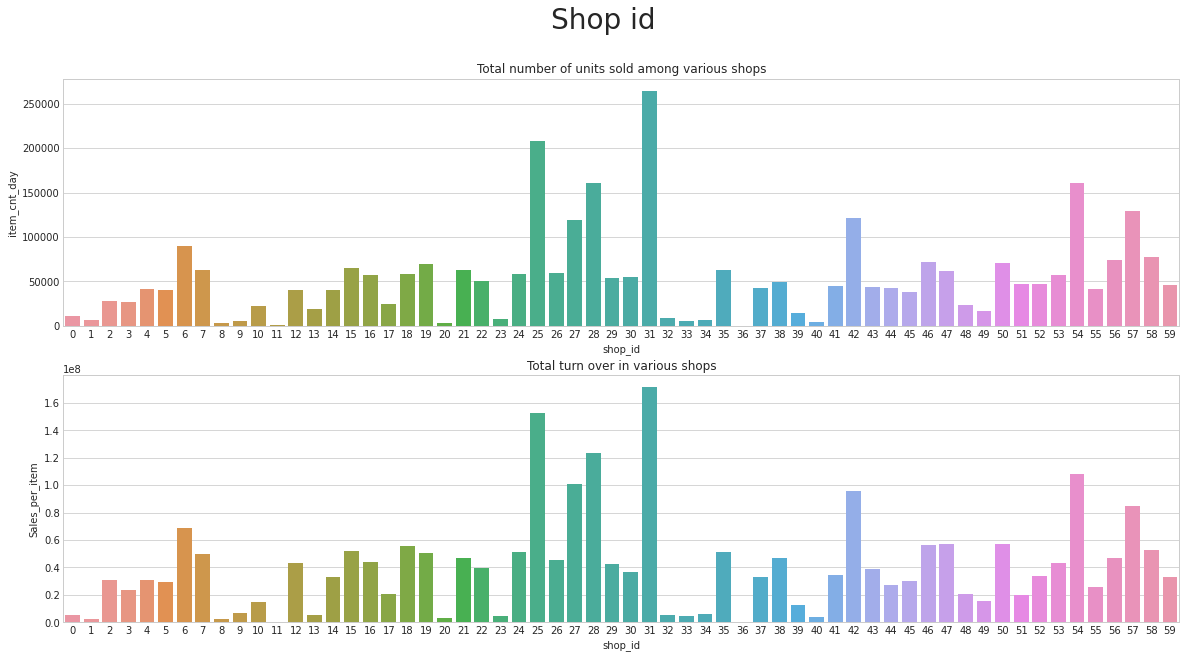

In [30]:
fig, axes = plt.subplots(2,1,figsize=(20,10))
sns.barplot(x=df_tmp["shop_id"],y=df_tmp["item_cnt_day"],ax=axes[0])
axes[0].set_title("Total number of units sold among various shops")
sns.barplot(x=df_tmp["shop_id"],y=df_tmp["Sales_per_item"],ax=axes[1])
axes[1].set_title('Total turn over in various shops')
plt.suptitle('Shop id', fontsize="28")
plt.show()

In [31]:
print(f'Total number of unique item ids: {df["item_id"].nunique()}')

df_tmp = df[["item_id","Sales_per_item","item_cnt_day"]]
df_tmp= pd.pivot_table(data=df_tmp,index=["item_id"],aggfunc={"item_cnt_day":np.sum,"Sales_per_item":np.sum}).reset_index()
df_tmp_sales = df_tmp.sort_values(by=['Sales_per_item'],ascending=False).head(50).reset_index(drop=True)
df_tmp_count = df_tmp.sort_values(by=['item_cnt_day'],ascending=False).head(50).reset_index(drop=True)

Total number of unique item ids: 21804


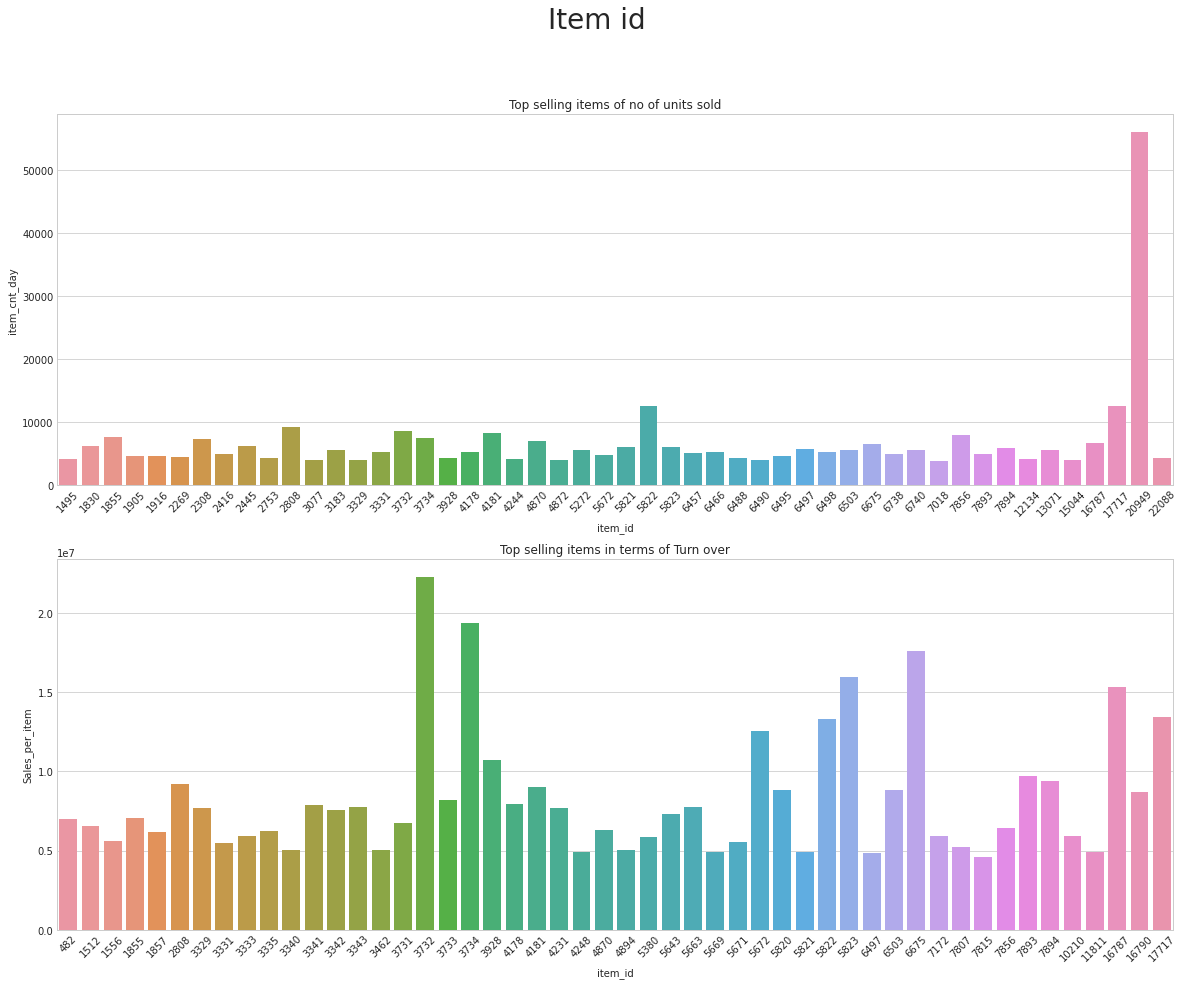

In [32]:
fig, axes = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=df_tmp_count["item_id"],y=df_tmp_count["item_cnt_day"],ax=axes[0])
axes[0].set_title("Top selling items of no of units sold")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45)
sns.barplot(x=df_tmp_sales["item_id"],y=df_tmp_sales["Sales_per_item"],ax=axes[1])
axes[1].set_title('Top selling items in terms of Turn over')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45)
plt.suptitle('Item id', fontsize="28")
plt.show()

In [33]:
print(f'Total number of unique item categorical ids: {df["item_category_id"].nunique()}')

df_tmp = df[["item_category_id","Sales_per_item","item_cnt_day"]]
df_tmp= pd.pivot_table(data=df_tmp,index=["item_category_id"],aggfunc={"item_cnt_day":np.sum,"Sales_per_item":np.sum}).reset_index()
df_tmp_sales = df_tmp.sort_values(by=['Sales_per_item'],ascending=False).head(50).reset_index(drop=True)
df_tmp_count = df_tmp.sort_values(by=['item_cnt_day'],ascending=False).head(50).reset_index(drop=True)

Total number of unique item categorical ids: 84


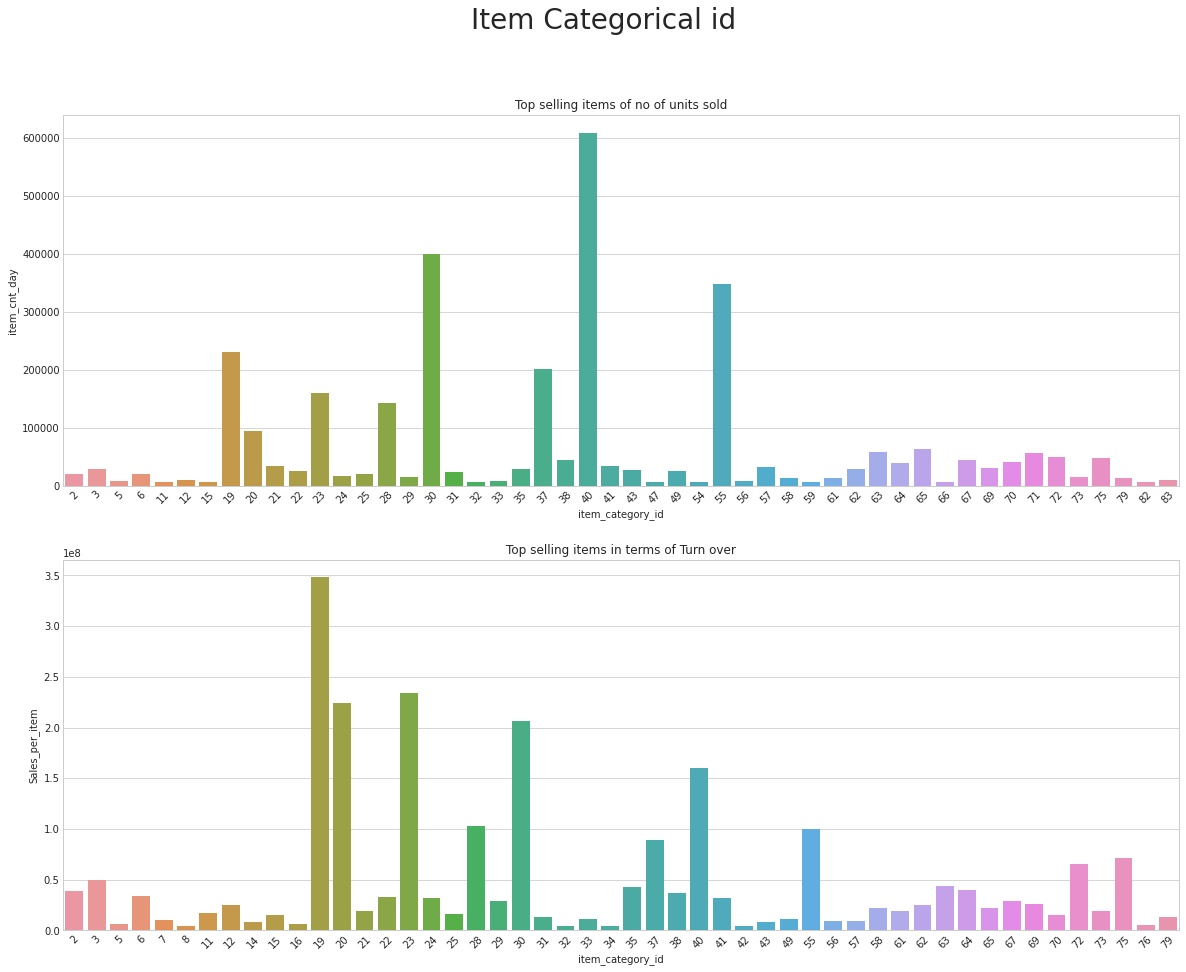

In [34]:
fig, axes = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=df_tmp_count["item_category_id"],y=df_tmp_count["item_cnt_day"],ax=axes[0])
axes[0].set_title("Top selling items of no of units sold")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45)
sns.barplot(x=df_tmp_sales["item_category_id"],y=df_tmp_sales["Sales_per_item"],ax=axes[1])
axes[1].set_title('Top selling items in terms of Turn over')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45)
plt.suptitle('Item Categorical id', fontsize="28")
plt.show()
del df_tmp,df_tmp_count,df_tmp_sales

- We have maxium units sold as well as maxiumum sales in shop id 31.
- We have maximum units sold for item 20949. But maximum sales in terms of Turn over is for item number 3732. Its more over like selling of chocolate and television.
- Similarly for item categories, we have maximum number of unit sold for item_category_id 40 while maximum sales in terms of turn over occured to category id 19.

- Do an item belongs to single category or not?

In [35]:
item_categories = df['item_category_id'].unique()
tmp = df[['item_id','item_category_id']].groupby(by="item_id").nunique().reset_index()
tmp.head()

,item_id,item_category_id
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [36]:
tmp['item_category_id'].unique()

array([1])

- there is only 1 category corresponding to a `item_id`

### 2-(5). Analysis of monthly sales

In [37]:
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month
df["day_of_month"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.day_of_week

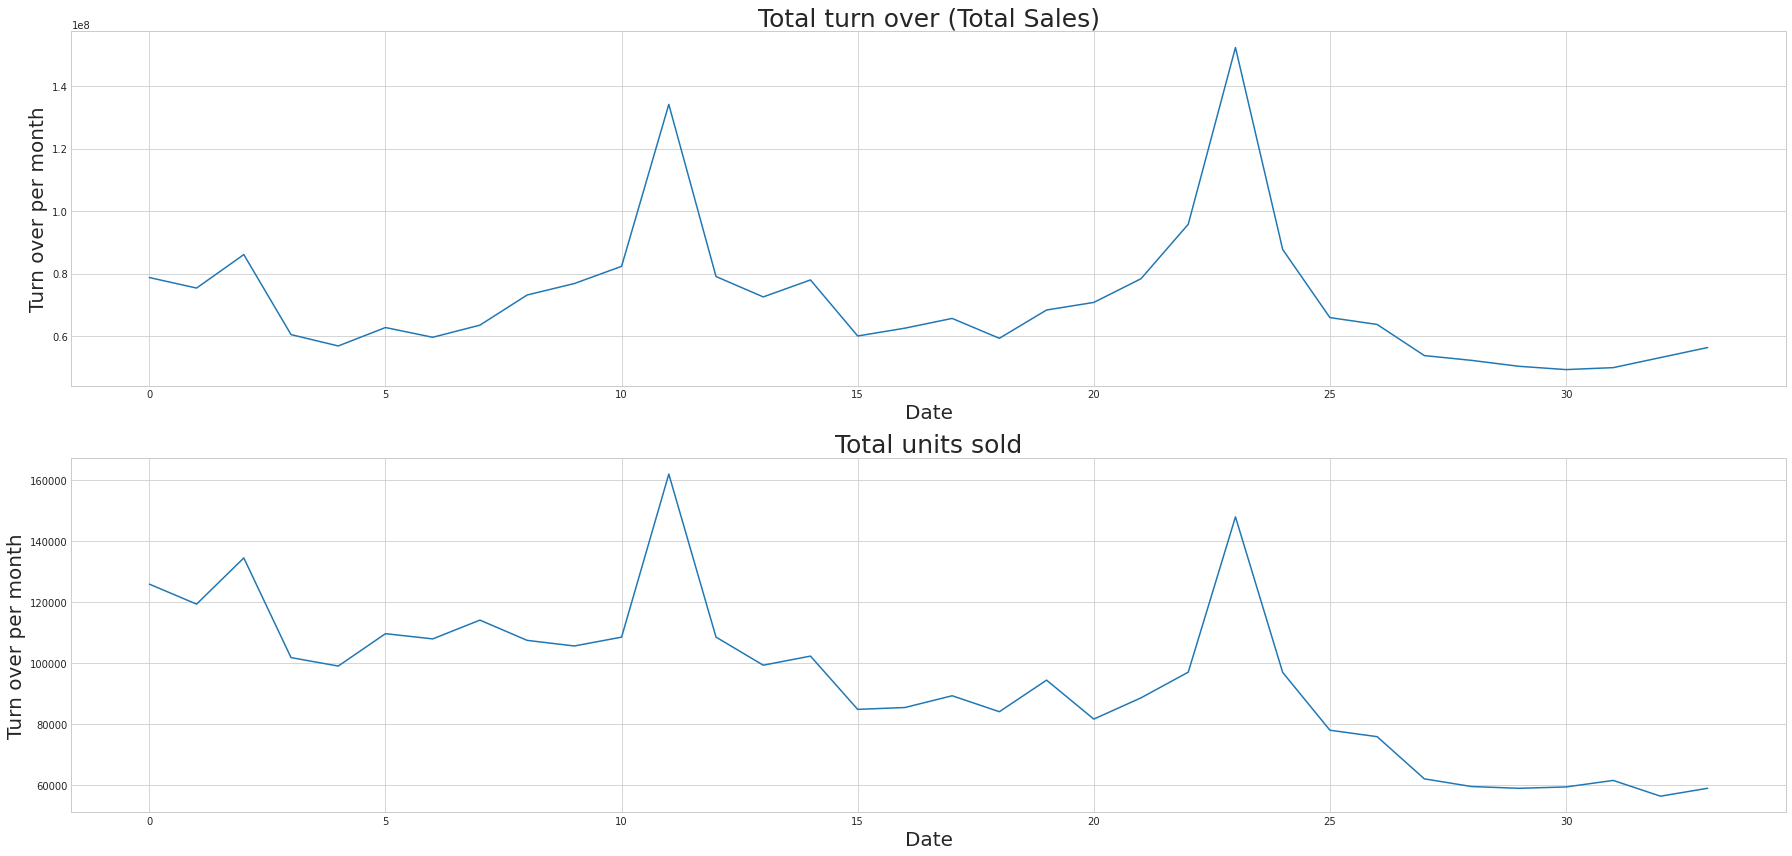

In [38]:
fig,axes = plt.subplots(2,1, figsize=(25,12))
df_tmp = df[['date_block_num','Month','Sales_per_item']].groupby(by=['date_block_num']).aggregate("sum").reset_index()
sns.lineplot(x=df_tmp['date_block_num'],y=df_tmp['Sales_per_item'],ax=axes[0])
axes[0].set_title('Total turn over (Total Sales)',fontsize="25")
axes[0].set_xlabel('Date',fontsize="20")
axes[0].set_ylabel('Turn over per month',fontsize="20")


df_tmp = df[['date_block_num','Month','item_cnt_day']].groupby(by=['date_block_num']).aggregate("sum").reset_index()
sns.lineplot(x=df_tmp['date_block_num'],y=df_tmp['item_cnt_day'],ax=axes[1])
axes[1].set_title('Total units sold',fontsize="25")
axes[1].set_xlabel('Date',fontsize="20")
axes[1].set_ylabel('Turn over per month',fontsize="20")

plt.tight_layout()
del df_tmp
plt.show()

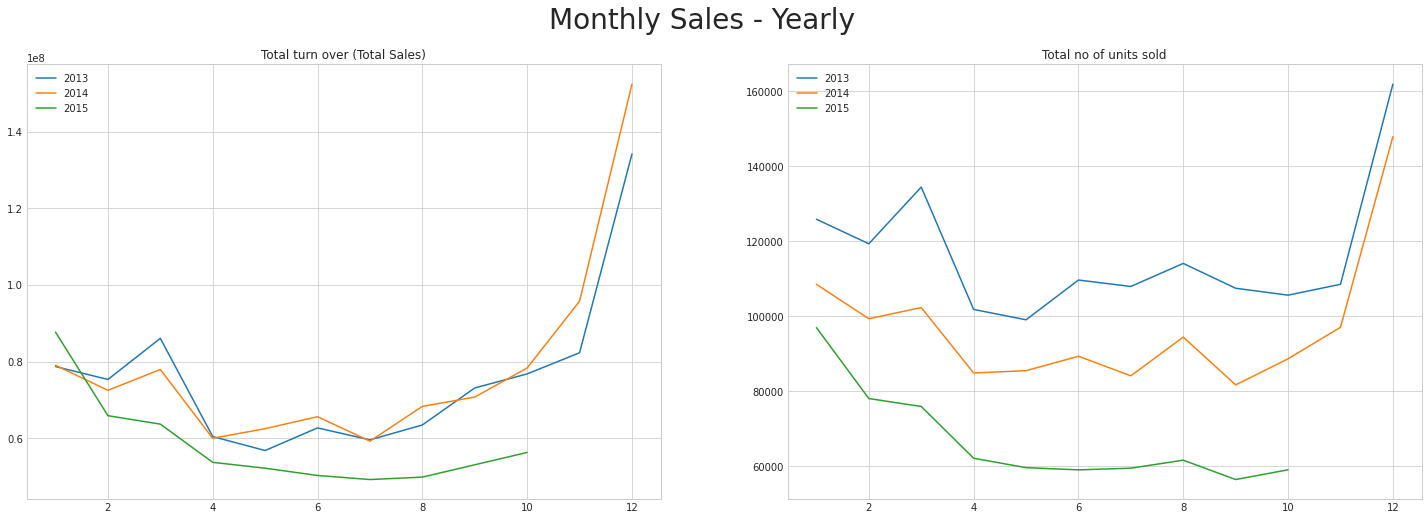

In [39]:
fig,axes = plt.subplots(1,2,figsize=(25,8))
df_tmp = df[['Year','Month','Sales_per_item']].pivot_table(index=['Month'],columns=['Year'],aggfunc={"Sales_per_item":np.sum})
axes[0].plot(df_tmp)
axes[0].set_title('Total turn over (Total Sales)')
axes[0].legend(labels=[i[1] for i in df_tmp.columns])

df_tmp = df[['Year','Month','item_cnt_day']].pivot_table(index=['Month'],columns=['Year'],aggfunc={"item_cnt_day":np.sum})
axes[1].plot(df_tmp)
axes[1].set_title('Total no of units sold')
axes[1].legend(labels=[i[1] for i in df_tmp.columns])
plt.suptitle('Monthly Sales - Yearly',fontsize="28")
plt.show()

- The umber of products sold as well as total turnover over the months follow almost same pattern.
- We have maximum sales in the month of november and december.
- Since we are predicting sales for november 2015, we expect a raise in no. of units sold

- Do all the shops sold items on all months from 2013 Jan to 2015 Oct
- Do some shops is deactive on mean time and become active again?

In [40]:
df_tmp = df[['date_block_num','shop_id','item_cnt_day']]
df_tmp.groupby(by='date_block_num').aggregate({'shop_id':'nunique'}).reset_index()

,date_block_num,shop_id
0,0,45
1,1,46
2,2,46
3,3,45
4,4,45
5,5,46
6,6,46
7,7,45
8,8,45
9,9,46


In [41]:
df_tmp = df[['date_block_num','shop_id','item_cnt_day']]
dt = pd.pivot_table(index='date_block_num',data=df_tmp,columns='shop_id',aggfunc="sum").reset_index(drop=True)
dt = dt.item_cnt_day
dt.columns.name = 'Month'
dt

Month,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,5334.00,2873.00,1137.00,767.00,2049.00,NaN,3550.00,2453.00,1451.00,NaN,...,3272.00,2567.00,1755.00,2013.00,8540.00,NaN,3173.00,NaN,NaN,1981.00
1,5718.00,3238.00,484.00,795.00,1957.00,871.00,3664.00,2421.00,1142.00,NaN,...,2909.00,2142.00,1646.00,1836.00,7205.00,NaN,2567.00,NaN,NaN,1808.00
2,NaN,NaN,724.00,943.00,1983.00,1344.00,3956.00,2317.00,973.00,NaN,...,3347.00,2473.00,1907.00,2244.00,8375.00,NaN,3011.00,6185.00,3657.00,1900.00
3,NaN,NaN,577.00,645.00,269.00,997.00,3009.00,1534.00,NaN,NaN,...,2658.00,1837.00,1411.00,1463.00,6176.00,NaN,2123.00,5290.00,2787.00,1352.00
4,NaN,NaN,549.00,696.00,1186.00,1099.00,2856.00,1615.00,NaN,NaN,...,2766.00,2093.00,1371.00,1660.00,6184.00,808.00,2091.00,5003.00,2262.00,1283.00
5,NaN,NaN,794.00,759.00,1405.00,1339.00,3402.00,1987.00,NaN,NaN,...,3255.00,1998.00,1677.00,1982.00,6874.00,665.00,2828.00,5397.00,2804.00,1577.00
6,NaN,NaN,804.00,687.00,1366.00,1235.00,3181.00,1971.00,NaN,NaN,...,3070.00,2194.00,1573.00,1909.00,6316.00,733.00,3133.00,5470.00,2969.00,1681.00
7,NaN,NaN,853.00,859.00,1682.00,1498.00,3384.00,2289.00,NaN,NaN,...,3474.00,2049.00,1708.00,2207.00,6931.00,659.00,3180.00,5125.00,2813.00,1980.00
8,NaN,NaN,824.00,897.00,1355.00,1214.00,3415.00,2231.00,NaN,NaN,...,3083.00,1792.00,1839.00,2051.00,6166.00,751.00,2539.00,4774.00,2613.00,1758.00
9,NaN,NaN,715.00,772.00,1343.00,1209.00,3061.00,2049.00,NaN,2389.00,...,3042.00,1710.00,1713.00,1958.00,5567.00,828.00,2230.00,4915.00,2796.00,1607.00


- We have a total of 60 shops. But all of them are note active during all the months
- For example in case of shop id 9, it is active only in 9th, 21th and 33th month. 
  - Shop id 0 and shop id 1 is only active in first two months. Shop id 52 is active on all the months.(From above pivot table)
- We can see that some of the shops are not active in certain months and again they become active
- On feature engineering we can create lag average of sales on shops as a feature.

## **3. Feature Engineering**

In [42]:
def remove_outliers(df):
    #remove outliers from item_cnt_day
    df = df[df['item_cnt_day'] >= 0]
    upper_quantile = df['item_cnt_day'].quantile(0.95)
    df['item_cnt_day'] = np.where(df['item_cnt_day'] > upper_quantile, upper_quantile, df['item_cnt_day'])
    
    df = df[df['item_price'] >= 0]
    upper_quantile = df['item_price'].quantile(0.95)
    df['item_price'] = np.where(df['item_price'] > upper_quantile, upper_quantile, df['item_price'])
    return df

In [43]:
#load the merged data
df_train = dff.copy()
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
print(df_train.shape, df_test.shape)

(2935849, 9) (214200, 3)


In [44]:
# removing outliers
df_train = remove_outliers(df_train)
df_train.shape

(2928492, 9)

In [45]:
#clippping values as per kaggle discussion
df_train['item_cnt_day'] = df_train['item_cnt_day'].clip(0,20)

- We have about 60 unique shop id and 21804 unique item id in train data.
- We have about 42 shop id and 5100 unique item id in test data.
- First we will create a dataframe with each all shop id item id combinations in train. We will create it for all 34 months. 
- All shop ids and item ids wont be present in all the months.

In [46]:
from itertools import product

ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']

for i in range(34):
    
    # for each month, we are appending all month,shop_id,item_id combinations
    sales = df_train[df_train['date_block_num']==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
        
# creating a dataframe from list
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# convert to np.int8 to reduce memory usage
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix = matrix.reset_index(drop=True)
print(f'{time.time() - ts}')

18.62792468070984


In [47]:
print(matrix.shape)
matrix.head()

(10884554, 3)


,date_block_num,shop_id,item_id
0,0,0,19
1,0,0,27
2,0,0,28
3,0,0,29
4,0,0,32


In [48]:
df_test['date_block_num'] = 34

# conacting with train matrix
matrix = pd.concat([matrix,df_test],axis=0).reset_index(drop=True)

matrix.shape

(11098754, 4)

### 3-(1). Total number of each item sold per month for each shop
- [sum aggregation] - item_cnt_month

In [49]:
# example
df_train.loc[(df_train['date_block_num'] == 0) &  (df_train['shop_id'] == 0) & (df_train['item_id'] == 32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
1374240,03.01.2013,0,0,32,221.00,2.00,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1374241,21.01.2013,0,0,32,221.00,2.00,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1374242,25.01.2013,0,0,32,221.00,1.00,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1374243,31.01.2013,0,0,32,221.00,1.00,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"


- We can have same item sold on same shop on same month on different days. So we will do an sum aggregation on item_cnt day on combination of `date_block_num`, `shop_id`, `item_id`

In [50]:
tmp = df_train[['date_block_num','shop_id','item_id','item_cnt_day']]
tmp = tmp.groupby(by=['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'})
tmp.columns = ['item_cnt_month']
tmp = tmp.reset_index(drop=False)
tmp.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.00
1,0,0,33,3.00
2,0,0,35,1.00
3,0,0,43,1.00
4,0,0,51,2.00


In [51]:
#merging with main frame
matrix = matrix.merge(tmp,on=['date_block_num','shop_id','item_id'],how='left')
matrix = matrix.fillna(0)

#clip values of max items sold per month to 20
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
del tmp

In [52]:
matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month
0,0,0,19,0.00,0.00
1,0,0,27,0.00,0.00
2,0,0,28,0.00,0.00
3,0,0,29,0.00,0.00
4,0,0,32,0.00,6.00


### 3-(2). Lag Features

In [53]:
def lag_feature(df, lags, col):
    """
    creates a lag feature. eg: item_cnt_month corresponding to a shop_id item_id combination of previous month, 
    previous second month etc
    """
    
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

- Let us create lag features on item_cnt_month from lag 1 to lag 12.

In [54]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'item_cnt_month')
#fill missing values
matrix = matrix.fillna(0)
time.time() - ts

97.98606944084167

## **4. Modeling**

#### Train and test split
- months 11 to month 33 -> train data  (since we are taking 12 months lag)
- month 33 -> validation data
- month 34 -> test data (provided in competition)

In [55]:
feats = [i for i in matrix.columns if 'lag' in i] + ['shop_id','item_id','date_block_num','item_cnt_month']

data = matrix[feats]

train_df = data.loc[(data['date_block_num'] > 11) & (data['date_block_num'] < 33)]
val_df = data.loc[data['date_block_num'] == 33]
test_df = data.loc[data['date_block_num'] == 34]

X_train = train_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_train = train_df['item_cnt_month']
X_val = val_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_val = val_df['item_cnt_month']
X_test = test_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6167580, 12) (6167580,)
(238084, 12) (238084,)


In [56]:
# del matrix
del data
del train_df
del val_df
del test_df

### 4-(1). Random Forest

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(random_state=42,max_depth=5,n_estimators=50,min_samples_split=4)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

train_rmse = mean_squared_error(y_train,y_train_pred,squared=False)
val_rmse = mean_squared_error(y_val,y_val_pred,squared=False)

print(f'Train rmse: {train_rmse}')
print(f'Val rmse: {val_rmse}')

Train rmse: 0.8472916715358719
Val rmse: 0.7883139004626974


### 4-(2). Xgboost

In [58]:
import xgboost as xgb
ts = time.time()

model = xgb.XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:0.99001	validation_1-rmse:0.89773
[1]	validation_0-rmse:0.91739	validation_1-rmse:0.84090
[2]	validation_0-rmse:0.87880	validation_1-rmse:0.81123
[3]	validation_0-rmse:0.85690	validation_1-rmse:0.79462
[4]	validation_0-rmse:0.84795	validation_1-rmse:0.78744
[5]	validation_0-rmse:0.84423	validation_1-rmse:0.78416
[6]	validation_0-rmse:0.84129	validation_1-rmse:0.78216
[7]	validation_0-rmse:0.83721	validation_1-rmse:0.78008
[8]	validation_0-rmse:0.83505	validation_1-rmse:0.77929
[9]	validation_0-rmse:0.83404	validation_1-rmse:0.77884
[10]	validation_0-rmse:0.83337	validation_1-rmse:0.77890
[11]	validation_0-rmse:0.83294	validation_1-rmse:0.77903
[12]	validation_0-rmse:0.83265	validation_1-rmse:0.77903
[13]	validation_0-rmse:0.83252	validation_1-rmse:0.77911
[14]	validation_0-rmse:0.83234	validation_1-rmse:0.77922
[15]	validation_0-rmse:0.83221	validation_1-rmse:0.77933
[16]	validation_0-rmse:0.83206	validation_1-rmse:0.77929
[17]	validation_0-rmse:0.83191	validation

31.485252618789673

## **5. Improve our reslut**
### 5-(1). Feature engineering

#### Lag features based on average number of items sold per month.
- mean aggregation of `item_cnt_month` based on `date_block_num`

In [59]:
group = matrix.groupby(by=['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns = ['item_cnt_month_mean_date']
group = group.reset_index()

# merging with skelton
matrix = matrix.merge(group,on=['date_block_num'],how="left")

#adjusting datatype
matrix['item_cnt_month_mean_date'] = matrix['item_cnt_month_mean_date'].astype(np.float16)

In [60]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'item_cnt_month_mean_date')
#fill missing values
matrix = matrix.fillna(0)
# drop the unneeded feature
matrix = matrix.drop(columns=['item_cnt_month_mean_date'])
time.time() - ts

59.092254400253296

#### Lag features based on average number of items sold per month on each shop
- mean aggregation of `item_cnt_month` based on `[date_block_num,shop_id]`

In [61]:
group = matrix.groupby(by=['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group.columns = ['item_cnt_month_mean_date_shopid']
group = group.reset_index()

# merging with skelton
matrix = matrix.merge(group,on=['date_block_num','shop_id'],how="left")

#adjusting datatype
matrix['item_cnt_month_mean_date_shopid'] = matrix['item_cnt_month_mean_date_shopid'].astype(np.float16)

In [62]:
# LAG FEATURES

ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'item_cnt_month_mean_date_shopid')
#fill missing values
matrix = matrix.fillna(0)
# drop the unneeded feature
matrix.drop(columns=['item_cnt_month_mean_date_shopid'],inplace=True)
time.time() - ts

63.128512144088745

#### Lag features based on average number of each item sold per month
- mean aggregation of `item_cnt_month` based on `[date_block_num,item_id]`

In [63]:
group = matrix.groupby(by=['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns = ['item_cnt_month_mean_date_itemid']
group = group.reset_index()

# merging with skelton
matrix = matrix.merge(group,on=['date_block_num','item_id'],how="left")

#adjusting datatype
matrix['item_cnt_month_mean_date_itemid'] = matrix['item_cnt_month_mean_date_itemid'].astype(np.float16)

In [64]:
# LAG FEATURES

ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'item_cnt_month_mean_date_itemid')
#fill missing values
matrix = matrix.fillna(0)
# drop the unneeded feature
matrix.drop(columns=['item_cnt_month_mean_date_itemid'],inplace=True)
time.time() - ts

67.83809900283813

#### Lag features based on Revenue generated form each item of each month
- sales on item = `item_cnt_month`*`item_price`

In [65]:
# mean item price per item
df_train['revenue'] = df_train['item_cnt_day']*df_train['item_price']
item_id_price = df_train[['item_id','revenue','date_block_num']].groupby(by=['date_block_num','item_id']).agg({'revenue':['mean']})
item_id_price.columns = ['mean_revenue']
item_id_price = item_id_price.reset_index()
matrix = matrix.merge(item_id_price,on=['date_block_num','item_id'],how="left")
matrix['mean_revenue'] = matrix['mean_revenue'].astype(np.float16)

In [66]:
#lag features
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'mean_revenue')

for i in lags:
    matrix['mean_revenue_lag_'+str(i)] = matrix['mean_revenue_lag_'+str(i)].fillna(0)

### 5-(2). Final model

In [67]:
feats = [i for i in matrix.columns if 'lag' in i] + ['shop_id','item_id','date_block_num','item_cnt_month']

data = matrix[feats]
train_df = data.loc[(data['date_block_num'] > 11) & (data['date_block_num'] < 33)]
val_df = data.loc[data['date_block_num'] == 33]
test_df = data.loc[data['date_block_num'] == 34]

X_train = train_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_train = train_df['item_cnt_month']
X_val = val_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_val = val_df['item_cnt_month']
X_test = test_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])

print(X_train.shape,X_val.shape,X_test.shape)

(6167580, 36) (238084, 36) (214200, 36)


In [68]:
# del matrix
del data
del train_df
del val_df
del test_df

In [69]:
ts = time.time()

model = xgb.XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:0.98564	validation_1-rmse:0.89667
[1]	validation_0-rmse:0.90391	validation_1-rmse:0.83733
[2]	validation_0-rmse:0.86110	validation_1-rmse:0.80738
[3]	validation_0-rmse:0.83393	validation_1-rmse:0.78986
[4]	validation_0-rmse:0.81840	validation_1-rmse:0.78100
[5]	validation_0-rmse:0.80915	validation_1-rmse:0.77682
[6]	validation_0-rmse:0.80407	validation_1-rmse:0.77475
[7]	validation_0-rmse:0.79898	validation_1-rmse:0.77338
[8]	validation_0-rmse:0.79638	validation_1-rmse:0.77640
[9]	validation_0-rmse:0.79344	validation_1-rmse:0.77701
[10]	validation_0-rmse:0.79157	validation_1-rmse:0.77641
[11]	validation_0-rmse:0.78975	validation_1-rmse:0.77699
[12]	validation_0-rmse:0.78785	validation_1-rmse:0.77791
[13]	validation_0-rmse:0.78657	validation_1-rmse:0.77799
[14]	validation_0-rmse:0.78522	validation_1-rmse:0.77742
[15]	validation_0-rmse:0.78438	validation_1-rmse:0.77739
[16]	validation_0-rmse:0.78323	validation_1-rmse:0.77736


41.11238980293274

In [70]:
Y_test = model.predict(X_test).clip(0, 20)
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)